In [1]:
import sys
sys.path.append("/u/home/a/alejandr/bin")
sys.path.append("/u/home/x/xiyuyi/bin")
sys.path.append("G:\\DH_localization\\PyPRIS")
from PyPRIS import *
import os
print("")
print("")
print("")
import warnings
warnings.filterwarnings("ignore")

In [2]:
obj_fpath = 'G:\\DH_localization\\PyPRIS_CL_set1\\bgSCF12_mu1.0e+08_alpha1.0e-05_thres-17zrange-19to19_chosen\\saved_objects'
linbreg_fpath = obj_fpath+'\\PyPRIS_bgSCF12_mu1.0e+08_alpha1.0e-05_thres-17zrange-19to19_pris6_80000.file'
pypris_fpath = obj_fpath+'\\PyPRIS_pris6.file'

'''

load the linbreg object from the 0th order result

'''

with open(linbreg_fpath,'rb') as f:
    linb_ori = pickle.load(f)

with open(pypris_fpath,'rb') as f:
    pypris_ori = pickle.load(f)

pypris0 = PyPRIS()
linb0 = LinBreg('test')

In [3]:
for i in pypris0.__dict__.keys():
    str = 'pypris0.'+i+'=pypris_ori.'+i
    exec(str)
    
for i in linb_ori.__dict__.keys():
    str = 'linb0.'+i+'=linb_ori.'+i
    exec(str)

In [4]:
print(len(pypris0.current_candidates))
pypris0.candidate_pop(linb0, thres=10)
len(pypris0.current_candidates)


91480


7742

In [5]:
print(len(linb0.x))
linb0.match_popped_candidates(pypris0.survival_inds)
print(len(linb0.x))

91481
7743


In [6]:
# prepare a field shift observer
psf_path = 'G:\\DH_localization\\PyPRIS\\test_dataset_5\\psf_cropped_1st.tif'
img_1st_order_path = 'G:\\DH_localization\\PyPRIS\\test_dataset_5\\combined_1st.tif'
psf = io.imread(psf_path)
psf_1stOrder = psf
psf_0thOrder = io.imread('G:\\DH_localization\\PyPRIS\\test_dataset_5\\psf_cropped_0th.tif')
wshift_1stdiff = io.imread(img_1st_order_path)

observer = ObserveStation()
observer.observe_with_shift_prep(psf, single_image_size=[140,100], psfz0=35,
                                      shift_1=0, shift_2=0,
                                      observer_debugger=False, observer_edge_padding=True)

pypris0.observe = copy.deepcopy(observer.observe_with_shift)
pypris0.generate_sensing_mx()

----------- Generate sensing matrix:
            Matrix size: 14000  observation pixels 
                         7742  candidates 


In [7]:
# remove some background
filtered_x = copy.deepcopy(linb0.x)
for ind, m in enumerate(filtered_x):
    if m < 10:
        filtered_x[ind] = 0

In [8]:
type(linb0.x)

numpy.ndarray

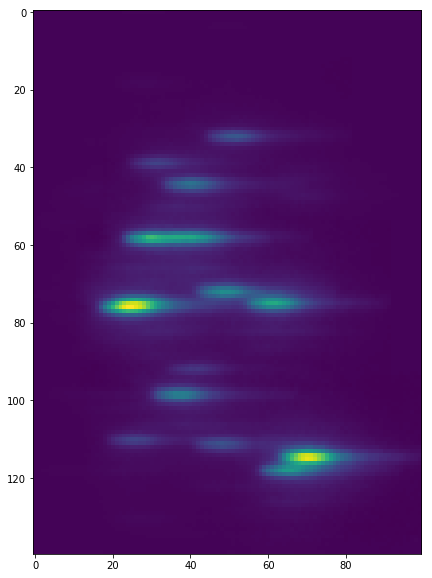

In [9]:
# shift free image
woshift_1stdiff = np.dot(pypris0.current_A, filtered_x).reshape(140,100)
plt.figure(figsize=(10,10))
plt.imshow(woshift_1stdiff)

In [10]:
from scipy import signal
from scipy import misc
a = wshift_1stdiff/np.max(wshift_1stdiff.ravel())
b = woshift_1stdiff/np.max(woshift_1stdiff.ravel())
corr = signal.correlate2d(a, b, boundary='fill', mode='same')
y, x = np.unravel_index(np.argmax(corr), corr.shape) # find the match
fitted_shift_1 = y - 68.65
fitted_shift_2 = x - 49
print(fitted_shift_1, fitted_shift_2)

-4.650000000000006 -2


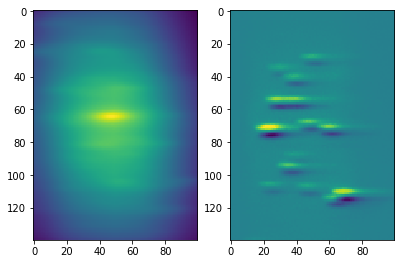

In [11]:
plt.figure(figsize=[10,5])
plt.subplot(131)
plt.imshow(corr)
plt.subplot(132)
plt.imshow(a - b)

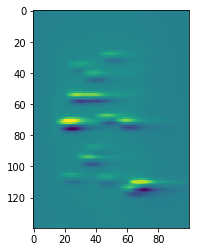

In [12]:

plt.imshow(a - b)

In [13]:
# now incorporate such shift into the obesrver, and check with difference image.
observer = ObserveStation()
observer.observe_with_shift_prep(psf, single_image_size=[140,100], psfz0=35,
                                      shift_1=fitted_shift_1, shift_2 = fitted_shift_2,
                                      observer_debugger=False, observer_edge_padding=True)

pypris0.observe = copy.deepcopy(observer.observe_with_shift)
pypris0.generate_sensing_mx()

----------- Generate sensing matrix:
            Matrix size: 14000  observation pixels 
                         7742  candidates 


In [14]:
incshift_1stdiff = np.dot(pypris0.current_A, filtered_x).reshape(140,100)
a = wshift_1stdiff/np.max(wshift_1stdiff.ravel())
b = woshift_1stdiff/np.max(woshift_1stdiff.ravel())
c = incshift_1stdiff/np.max(incshift_1stdiff.ravel())*1.4


Text(0.5,1,'wshift - incshift')

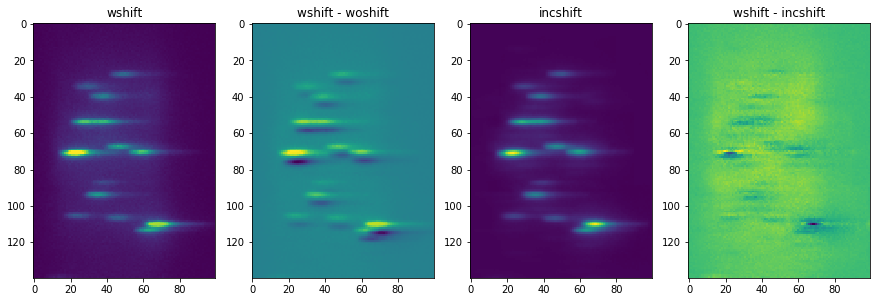

In [15]:
plt.figure(figsize=[15,10])
plt.subplot(141)
plt.imshow(a)
plt.title('wshift')
plt.subplot(142)
plt.imshow(a - b)
plt.title('wshift - woshift')
plt.subplot(143)
plt.imshow(c)
plt.title('incshift')
plt.subplot(144)
plt.imshow(a-c)
plt.title('wshift - incshift')


In [16]:
fitted_shift_1-137.5/2

-73.4

# now check the combined observation

In [25]:
observer = ObserveStation()

observer.observe_with_CL_and_grating_prep(psf_CL=psf_0thOrder, imsize_CL=[140,100], psfz0_CL=40,
                                    dist_1_amplitd=0.999, dist_1_shift=-0.922,
                                    dist_2_amplitd=0.813, dist_2_shift=9.459,
                                    psf_shift=psf_1stOrder, imsize_shift=[140,100], psfz0_shift=40,
                                    shift_1=fitted_shift_1, shift_2 = fitted_shift_2,
                                    observer_debugger=False, observer_edge_padding=True)
pypris0.observe = copy.deepcopy(observer.observe_with_CL_and_grating)
pypris0.observation = np.ndarray([28000,1])
pypris0.generate_sensing_mx()

----------- Generate sensing matrix:
            Matrix size: 28000  observation pixels 
                         7742  candidates 


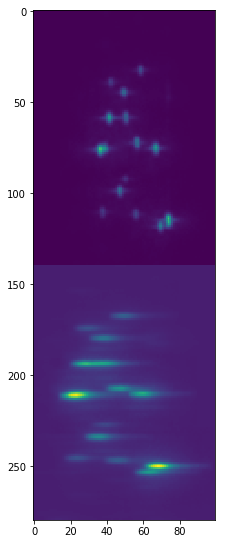

In [29]:
a = np.dot(pypris0.current_A, filtered_x).reshape(280,100)
plt.figure(figsize=[15,10])
plt.subplot(141)
plt.imshow(a)